# Recognition tables with text


In [1]:
name_jpg = '/home/al/MyProjects/NLP-russian-language/examples/recognition_text/sampel_1.jpg'

In [28]:
%matplotlib inline
import pytesseract
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import copy

In [29]:
def show_image (img, gray=False):
    fig = plt.figure(figsize=(20,10))
    plt.axis("off")
    if gray:
        plt.imshow(img, cmap="Greys")
    else:
        plt.imshow(img[...,::-1])
    plt.show()

## Вариант 1

 

№№
п/п

|

208 —

—

Аист..…?_;……‚_.

' Если был участником

 

 

 

 

 
  
 
  
   
  
  
 

   
   
   
  
 
   
 

ВС\В 1954 г. указать  [ПОказатели, по которым \Показатели, установлен- Предлагаемые награды н
Н ВСуВ: какие были показатели, | утвержден участником |ные Главным комитетом ® Заподняются
! аименовавие участника & Вр по которым присуждены ВСХВ 1955 гола ВЁЗХВ, для %ЁЗБСТИЯ на | Если награж- н премин
_ мИИ ыставке года - .
Литер — |указывается фамилия, имя, отчество передовика Наименование награды и пре . ЁЁЁЁЗЁЁУ
и номер и полное название хозяйства или организация, | кудьтуры, продуктивно- — л - - — - 1954 года, то :
ы . урожай урожай Урожай  |указать-какие |  для ХОЗЯЙСТВ
по списку района, сельсовета (для совхозов, заводов, сти животноводства площадь в центн. площадь в центн. площадь в центн. награды и и организаций Премни
участников кроме того, наименование Министерства}, ` и ?. д. ` (га) с 1 га, (га) с 1 га, (га) с 1 га, | премии были дипломы "| (для хозяйств
Выста

 | 602 | 1274 | 3128 | 67
торной | 602 | 1278 | 194 | 55
станции, | 837 | 1285 | 255 | 45
БольШё- | 1104 | 1274 | 229 | 52
ЛТ-?" | 1499 | 1289 | 135 | 47
при | 1705 | 1296 | 96 | 45
Малая | 3563 | 1291 | 167 | 44
 | 529 | 1350 | 882 | 143
 | 529 | 1350 | 882 | 143
 | 608 | 1350 | 803 | 66
сельского | 608 | 1362 | 291 | 36
района/п.Отд. | 934 | 1360 | 367 | 56
 | 529 | 1435 | 708 | 58
| | 529 | 1435 | 2 | 2
Большое | 570 | 1446 | 231 | 46
село,ст. | 840 | 1446 | 257 | 47
ЛОМ | 1151 | 1442 | 86 | 39
 | 1469 | 1363 | 2524 | 135
 | 1469 | 1363 | 2524 | 135
 | 1474 | 1363 | 2519 | 71
хорошем | 1474 | 1380 | 229 | 48
ка- | 1737 | 1380 | 98 | 54
серебрян | 3533 | 1363 | 264 | 54
{ | 3793 | 1358 | 35 | 69
Часы | 3863 | 1377 | 130 | 46
 | 1469 | 1442 | 399 | 56
честве | 1469 | 1453 | 198 | 36
рабо- | 1702 | 1442 | 166 | 56
 | 1472 | 1511 | 2331 | 59
 | 1472 | 1511 | 2331 | 59
 | 1472 | 1511 | 2331 | 59
ты | 1472 | 1525 | 64 | 36
_ | 1762 | 1511 | 60 | 59
ррр | 1880 | 1511 | 880 | 59
поЛЛЛЛЛЛЛЛЛ

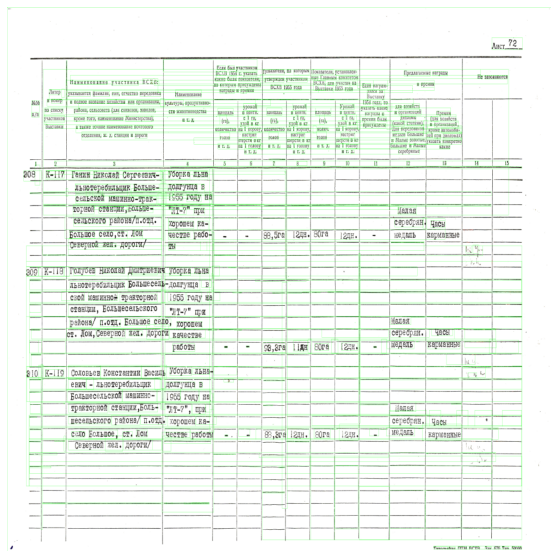

In [46]:
img = cv2.imread(name_jpg)
img[np.where((img > [0,0,150]).all(axis=2))] = [255,255,255]
img_rez = img
#img_rez = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
d = pytesseract.image_to_data(img_rez, output_type=pytesseract.Output.DICT, lang="rus")
#print(d['text'])
print(pytesseract.image_to_string(img_rez, lang="rus"))
n_boxes = len(d['level'])
for i in range(n_boxes):
    (t, x, y, w, h) = (d['text'][i],d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    img_rez = cv2.rectangle(img_rez, (x, y), (x + w, y + h), (0, 255, 0), 1)
    print(t, x, y, w, h, sep=' | ')

image1 = cv2.resize(img_rez, (1000,1000), interpolation=cv2.INTER_AREA)
show_image(image1)

## Вариант 2

In [12]:
# This only works if there's only one table on a page
# Important parameters:
#  - morph_size
#  - min_text_height_limit
#  - max_text_height_limit
#  - cell_threshold
#  - min_columns


def pre_process_image(img, morph_size=(10, 10)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    return pre


In [13]:
def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes

In [14]:
def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells

In [15]:
def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines

1022


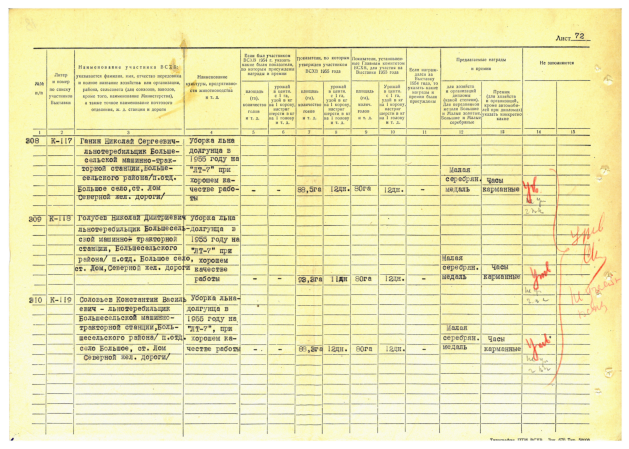

In [16]:
pre_processed = pre_process_image(img)
text_boxes = find_text_boxes(pre_processed)
print(len(text_boxes))
show_image(img)

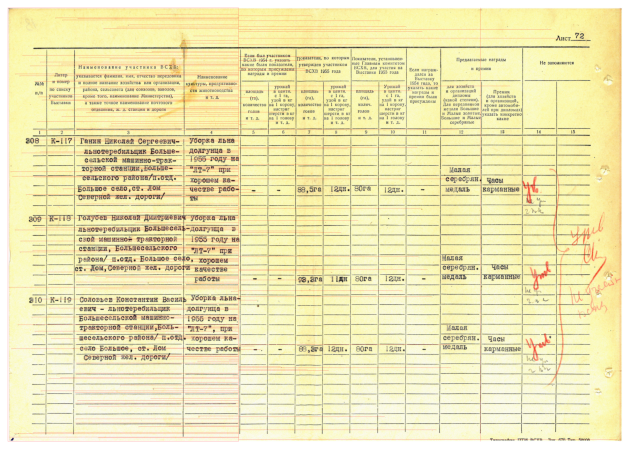

In [17]:
cells = find_table_in_boxes(text_boxes)
hor_lines, ver_lines = build_lines(cells)

# Visualize the result
vis = img.copy()

# for box in text_boxes:
#     (x, y, w, h) = box
#     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

for line in hor_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

for line in ver_lines:
    [x1, y1, x2, y2] = line
    cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

show_image(vis)